### Origen archivo geometria por seccion censal

https://opendata-ajuntament.barcelona.cat/data/es/dataset/20170706-districtes-barris/resource/e16856a7-b3c0-4c32-a468-cc190cbbf7a9?inner_span=True

### Datos Demograficos

https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_mdbas_edat-1/resource/d183032d-c508-45ca-b820-e9f1f7d8e01a

In [33]:
import pandas as pd

# Cargar los datos de los archivos CSV, transformar datos de seccion censal y convertir columnas preparando el merge
df_data = pd.read_csv('datos_demograficos.csv')
df_geometria = pd.read_csv('geometria.csv')

df_data['Seccio_Censal'] = df_data['Seccio_Censal'].apply(lambda x: str(x)[-3:])
df_data['Seccio_Censal'] = df_data['Seccio_Censal'].astype(int).astype(str).str.zfill(3)

df_data['Codi_Districte'] = df_data['Codi_Districte'].astype(str).str.zfill(2)
df_data['Codi_Barri'] = df_data['Codi_Barri'].astype(str).str.zfill(2)
df_data['AEB'] = df_data['AEB'].astype(str).str.zfill(3)
df_data['Seccio_Censal'] = df_data['Seccio_Censal'].astype(str).str.zfill(3)

df_geometria['Codi_Districte'] = df_geometria['codi_districte'].astype(str).str.zfill(2)
df_geometria['Codi_Barri'] = df_geometria['codi_barri'].astype(str).str.zfill(2)
df_geometria['AEB'] = df_geometria['codi_aeb'].astype(str).str.zfill(3)
df_geometria['Seccio_Censal'] = df_geometria['codi_seccio_censal'].astype(str).str.zfill(3)

In [34]:
# Realizar la unión de los dataframes
df_merged = pd.merge(df_data, df_geometria, on=['Codi_Districte', 'Codi_Barri', 'AEB', 'Seccio_Censal'], how='left')

print(df_merged.head())

  Data_Referencia Codi_Districte Nom_Districte Codi_Barri Nom_Barri  AEB  \
0      2022-01-01             01  Ciutat Vella         01  el Raval  001   
1      2022-01-01             01  Ciutat Vella         01  el Raval  001   
2      2022-01-01             01  Ciutat Vella         01  el Raval  001   
3      2022-01-01             01  Ciutat Vella         01  el Raval  001   
4      2022-01-01             01  Ciutat Vella         01  el Raval  001   

  Seccio_Censal Valor  EDAT_1  codi_districte nom_districte  codi_barri  \
0           001    16       0               1  Ciutat Vella           1   
1           001    13       1               1  Ciutat Vella           1   
2           001    13       2               1  Ciutat Vella           1   
3           001    15       3               1  Ciutat Vella           1   
4           001    14       4               1  Ciutat Vella           1   

  nom_barri  codi_aeb  codi_seccio_censal  \
0  el Raval         1                   1   
1 

In [35]:
#Comprobamos que esté ok el merge viendo que no hay datos nulos
print(df_merged.describe())
print(df_merged.info())
print(df_merged.isnull().sum())

              EDAT_1  codi_districte     codi_barri       codi_aeb  \
count  104782.000000   104782.000000  104782.000000  104782.000000   
mean       48.609227        5.716325      33.184345     119.689641   
std        28.405827        2.935466      21.865197      65.310183   
min         0.000000        1.000000       1.000000       1.000000   
25%        24.000000        3.000000      13.000000      63.000000   
50%        49.000000        6.000000      31.000000     122.000000   
75%        73.000000        8.000000      52.000000     175.000000   
max       100.000000       10.000000      73.000000     233.000000   

       codi_seccio_censal  
count       104782.000000  
mean            60.662108  
std             41.563899  
min              1.000000  
25%             28.000000  
50%             54.000000  
75%             87.000000  
max            237.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104782 entries, 0 to 104781
Data columns (total 17 columns):
 #   C

In [36]:
df_merged = df_merged.rename(columns={'EDAT_1': 'edad'})

# Filtrar los registros donde la edad sea de 0 a 3 años
df_filtered = df_merged[df_merged['edad'].between(0, 3)].copy()

df_filtered.loc[:, 'Total de 0 a 3'] = pd.to_numeric(df_filtered['Valor'], errors='coerce')

# Agrupar por Codi_Districte, nom_districte, AEB, nom_barri, Seccio_Censal y geometria_wgs84, y sumar los valores de la columna 'Total de 0 a 3'
grouped_df = df_filtered.groupby(['Codi_Districte', 'nom_districte', 'AEB', 'nom_barri', 'Seccio_Censal', 'geometria_wgs84']).agg({'Total de 0 a 3': 'sum'}).reset_index()

print(grouped_df)

     Codi_Districte nom_districte  AEB            nom_barri Seccio_Censal  \
0                01  Ciutat Vella  001             el Raval           001   
1                01  Ciutat Vella  001             el Raval           002   
2                01  Ciutat Vella  002             el Raval           003   
3                01  Ciutat Vella  002             el Raval           004   
4                01  Ciutat Vella  003             el Raval           005   
...             ...           ...  ...                  ...           ...   
1063             10    Sant Martí  232  la Verneda i la Pau           139   
1064             10    Sant Martí  233  la Verneda i la Pau           140   
1065             10    Sant Martí  233  la Verneda i la Pau           141   
1066             10    Sant Martí  233  la Verneda i la Pau           142   
1067             10    Sant Martí  233  la Verneda i la Pau           143   

                                        geometria_wgs84  Total de 0 a 3  
0

In [37]:
import geopandas as gpd
from shapely import wkt

# Convertir las columnas de geometría a objetos geométricos, crear GeoDataFrame y establecer un sistema de coordenadas
grouped_df['geometry'] = grouped_df['geometria_wgs84'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(grouped_df, geometry='geometry')

gdf.set_crs(epsg=4326, inplace=True)

print(gdf)

     Codi_Districte nom_districte  AEB            nom_barri Seccio_Censal  \
0                01  Ciutat Vella  001             el Raval           001   
1                01  Ciutat Vella  001             el Raval           002   
2                01  Ciutat Vella  002             el Raval           003   
3                01  Ciutat Vella  002             el Raval           004   
4                01  Ciutat Vella  003             el Raval           005   
...             ...           ...  ...                  ...           ...   
1063             10    Sant Martí  232  la Verneda i la Pau           139   
1064             10    Sant Martí  233  la Verneda i la Pau           140   
1065             10    Sant Martí  233  la Verneda i la Pau           141   
1066             10    Sant Martí  233  la Verneda i la Pau           142   
1067             10    Sant Martí  233  la Verneda i la Pau           143   

                                        geometria_wgs84  Total de 0 a 3  \


In [38]:
gdf['Total de 0 a 3'].sum()

45499.0

In [39]:
import pandas as pd
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar los puntos de referencia (GeoJSON), establecer mismo CRS y convertirlo a uno proyectado para calcular en metros y no en grados
gdf_puntos = gpd.read_file('hundredpoints.geojson')

gdf.set_crs(epsg=4326, inplace=True)
gdf_puntos.set_crs(epsg=4326, inplace=True)

gdf = gdf.to_crs(epsg=3857)
gdf_puntos = gdf_puntos.to_crs(epsg=3857)

accumulation_list = []

# Calcular la acumulación de 'Total de 0 a 3' dentro de un radio de 750 metros para cada punto con el que se intersecta
for idx, point in gdf_puntos.iterrows():
    buffer_geom = point['geometry'].buffer(750)
    
    polygons_in_buffer = gdf[gdf.geometry.intersects(buffer_geom)]
    
    total_sum = polygons_in_buffer['Total de 0 a 3'].sum()
    
    accumulation_list.append({
        'geometry': Point(point['geometry'].centroid.x, point['geometry'].centroid.y),
        'total_0_to_3': total_sum,
        'index': idx
    })

results_df = pd.DataFrame(accumulation_list)

assignment_table_gdf = gpd.GeoDataFrame(results_df, geometry='geometry', crs=gdf_puntos.crs)

# Convertir el CRS al valor correcto para su visualización
assignment_table_gdf = assignment_table_gdf.to_crs(epsg=4326)

# Normalizar los valores de 'total_0_to_3' entre 0 y 30 para asignarle la puntuación
scaler = MinMaxScaler(feature_range=(0, 30))
assignment_table_gdf['Puntuación'] = scaler.fit_transform(assignment_table_gdf[['total_0_to_3']]).round(2)

print("Total asignado a puntos de referencia:")
print(assignment_table_gdf)

resultados_gdf = assignment_table_gdf[['geometry','Puntuación']]
resultados_gdf.rename(columns={'Puntuación': 'menores3_score'}, inplace=True)

# Exportar el DataFrame a un archivo CSV
resultados_gdf.to_csv('resultados_menores3.csv')

Total asignado a puntos de referencia:
                     geometry  total_0_to_3  index  Puntuación
0    POINT (2.06332 41.42103)          54.0      0        0.04
1    POINT (2.06332 41.43048)          54.0      1        0.04
2    POINT (2.07430 41.41158)          54.0      2        0.04
3    POINT (2.07430 41.43048)          54.0      3        0.04
4    POINT (2.08528 41.41158)          54.0      4        0.04
..                        ...           ...    ...         ...
99   POINT (2.20608 41.41158)        1245.0     99       17.25
100  POINT (2.20608 41.42103)        1351.0    100       18.78
101  POINT (2.20608 41.43048)         348.0    101        4.29
102  POINT (2.20608 41.43994)         442.0    102        5.65
103  POINT (2.21706 41.41158)         810.0    103       10.96

[104 rows x 4 columns]


C:\Users\Toni\AppData\Local\Temp\ipykernel_20088\2144457176.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados_gdf.rename(columns={'Puntuación': 'menores3_score'}, inplace=True)


In [40]:
print(assignment_table_gdf['total_0_to_3'].sum())
print(grouped_df['Total de 0 a 3'].sum())
print(assignment_table_gdf.describe())
print(assignment_table_gdf.info())

77828.0
45499.0
       total_0_to_3       index  Puntuación
count    104.000000  104.000000   104.00000
mean     748.346154   51.500000    10.07250
std      616.118539   30.166206     8.89881
min       51.000000    0.000000     0.00000
25%      138.000000   25.750000     1.26000
50%      677.500000   51.500000     9.05000
75%     1272.750000   77.250000    17.64750
max     2128.000000  103.000000    30.00000
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      104 non-null    geometry
 1   total_0_to_3  104 non-null    float64 
 2   index         104 non-null    int64   
 3   Puntuación    104 non-null    float64 
dtypes: float64(2), geometry(1), int64(1)
memory usage: 3.4 KB
None


In [41]:
import folium

# Crear un mapa centrado alrededor de la media de latitud y longitud de marcadores
map_center = [assignment_table_gdf.geometry.y.mean(), assignment_table_gdf.geometry.x.mean()]
m = folium.Map(location=map_center, zoom_start=12)

for idx, row in assignment_table_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f'Total de 0 a 3: {row["total_0_to_3"]}',
        tooltip=row["total_0_to_3"]
    ).add_to(m)

m.save('Mapas/map_with_values.html')

m

In [42]:
import folium

# Crear mapa de calor con círculos de 750 m de radio y un punto en el centro 
map_center = [assignment_table_gdf['geometry'].y.mean(), assignment_table_gdf['geometry'].x.mean()]

m_heat = folium.Map(location=map_center, zoom_start=12)

colormap = folium.LinearColormap(colors=[ 'red', 'yellow','green'], vmin=assignment_table_gdf['total_0_to_3'].min(), vmax=assignment_table_gdf['total_0_to_3'].max())

for idx, row in assignment_table_gdf.iterrows():
    folium.Circle(
        location=[row.geometry.y, row.geometry.x],
        radius=750,
        color=colormap(row['total_0_to_3']),
        fill=True,
        fill_color=colormap(row['total_0_to_3']),
        fill_opacity=0.4,
        opacity=0.4,
        tooltip=f"Total de 0 a 3: {row['total_0_to_3']}<br>Puntuación: {row['Puntuación']}",
    ).add_to(m_heat)

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1,
        popup=f"Total de 0 a 3: {row['total_0_to_3']}<br>Puntuación: {row['Puntuación']}"
    ).add_to(m_heat)

colormap.add_to(m_heat)

# Guardar el mapa de calor en un archivo HTML
m_heat.save('Mapas/heat_map_score_menores3.html')

m_heat


In [43]:
import folium
from folium.plugins import HeatMap

# Crear mapa de calor con 
m_heat2 = folium.Map(location=map_center, zoom_start=12)

heat_data = [[row.geometry.y, row.geometry.x, row['total_0_to_3']] for idx, row in assignment_table_gdf.iterrows()]
HeatMap(heat_data).add_to(m_heat2)

for idx, row in assignment_table_gdf.iterrows():
    tooltip_text = f"Total de 0 a 3: {row['total_0_to_3']}<br>Puntuación: {row['Puntuación']}"
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1,
        popup=tooltip_text,
    ).add_to(m_heat2)

m_heat2.save('Mapas/heat_map2_score_menores3.html')

m_heat2

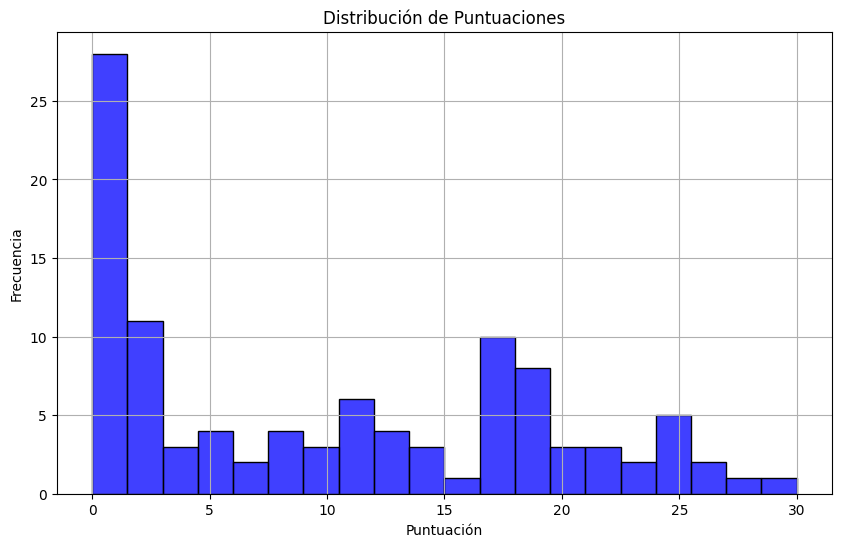

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un histograma de la distribución de puntuaciones
plt.figure(figsize=(10, 6))
sns.histplot(assignment_table_gdf['Puntuación'], bins=20, color='blue')
plt.title('Distribución de Puntuaciones')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.savefig('Imagenes/Histograma_Puntuaciones.png')
plt.show()


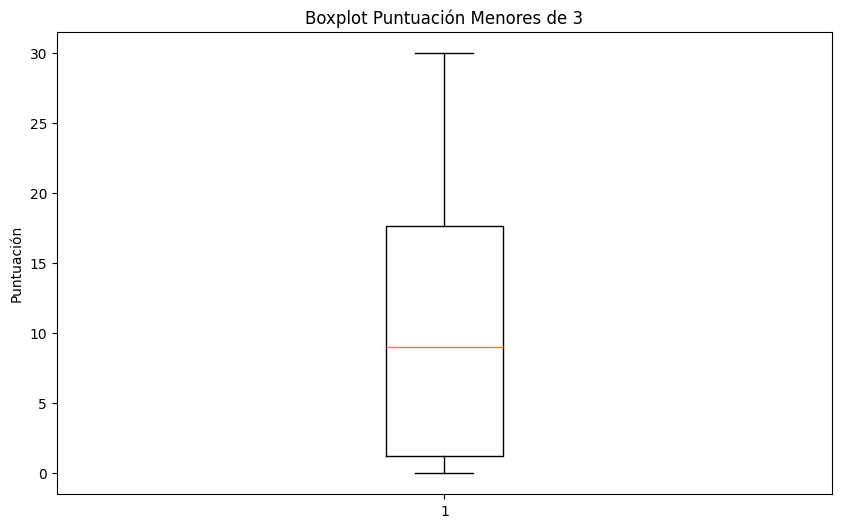

In [45]:
import matplotlib.pyplot as plt

# Crear el boxplot de puntuación
plt.figure(figsize=(10, 6))
plt.boxplot(assignment_table_gdf['Puntuación'])

plt.title('Boxplot Puntuación Menores de 3')
plt.ylabel('Puntuación')
plt.savefig('Imagenes/BoxPlot_Puntuacion_Menores3.png')

plt.show()

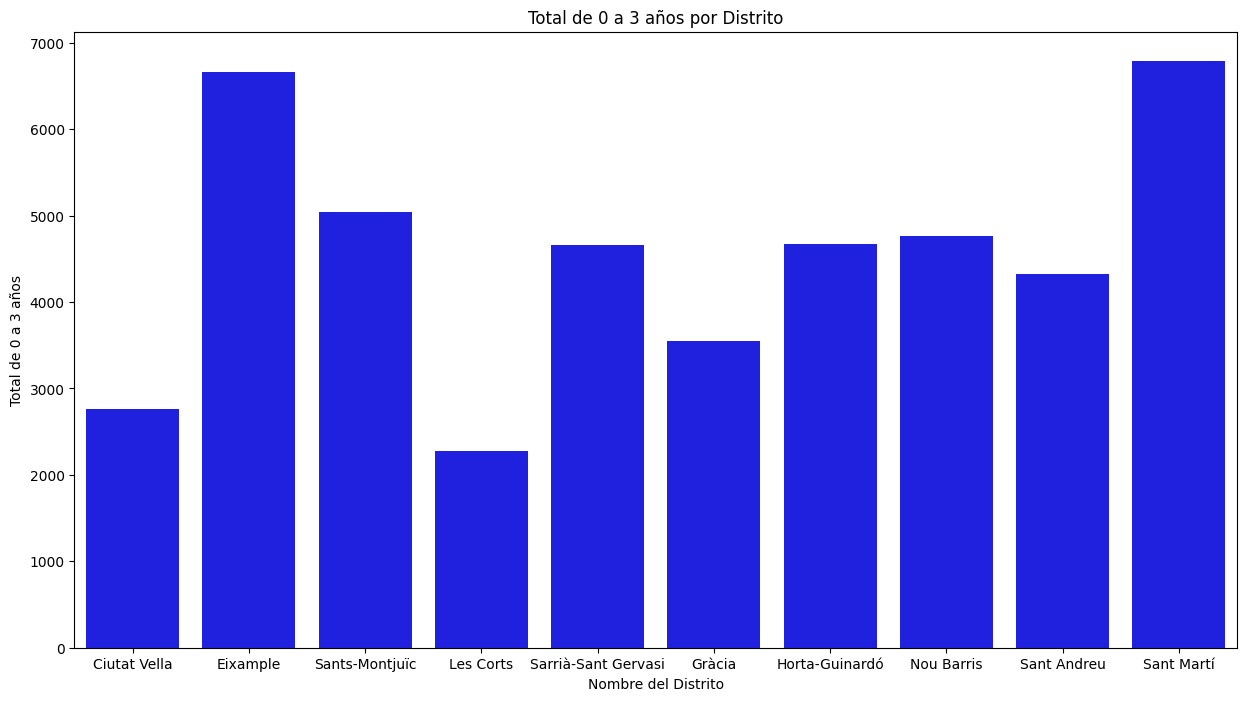

In [46]:
# Sumar los totales por distrito y obtener los nombres de los distritos
totals_by_district = gdf.groupby(['Codi_Districte', 'nom_districte'])['Total de 0 a 3'].sum().reset_index()

# Crear un diagrama de barras
plt.figure(figsize=(15, 8))
sns.barplot(x='nom_districte', y='Total de 0 a 3', data=totals_by_district, color='blue', legend=False)
plt.title('Total de 0 a 3 años por Distrito')
plt.xlabel('Nombre del Distrito')
plt.ylabel('Total de 0 a 3 años')
plt.savefig('Imagenes/Total_Por_Distrito.png')
plt.show()


In [47]:
import folium
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib.cm import ScalarMappable

# Crear un mapa centrado alrededor de la media de latitud y longitud de los puntos
map_center = [assignment_table_gdf.geometry.y.mean(), assignment_table_gdf.geometry.x.mean()]
marker_map_with_numbers_white = folium.Map(location=map_center, zoom_start=12)
marker_map_with_numbers_black = folium.Map(location=map_center, zoom_start=12)

norm = Normalize(vmin=assignment_table_gdf['Puntuación'].min(), vmax=assignment_table_gdf['Puntuación'].max())
cmap = plt.get_cmap('YlOrRd')
mappable = ScalarMappable(norm=norm, cmap=cmap)

for idx, row in assignment_table_gdf.iterrows():
    color = mappable.to_rgba(row['Puntuación'])
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=10,
        color='black',
        fill=True,
        fill_color=to_hex(color),
        fill_opacity=0.7,
        popup=f"Total de 0 a 3: {row['total_0_to_3']}<br>Puntuación: {row['Puntuación']}",
        tooltip=f"Total de 0 a 3: {row['total_0_to_3']}<br>Puntuación: {row['Puntuación']}"
    ).add_to(marker_map_with_numbers_white)
    
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.DivIcon(html=f'<div style="font-size: 12px; color: white;">{row["Puntuación"]}</div>'),
    ).add_to(marker_map_with_numbers_black)

# Guardar el mapa en archivo HTML
marker_map_with_numbers_white.save('Mapas/marker_map_with_numbers_white.html')

marker_map_with_numbers_white
